In [315]:
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using DelaunayTriangulation
using CircularArrays

@from "$(projectdir())/src/SenseCheck.jl" using SenseCheck
@from "$(projectdir())/src/TopologyChange.jl" using TopologyChange

@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions

In [3]:

function orderAroundCell(A,B, i)


    # Find all edges and vertices for cell i
    cellEdges = findall(j->j!=0,B[i,:])
    
    orderedVertices = Int64[] # Ordered list of vertices around cell i in clockwise direction 
    orderedEdges = Int64[]    # Ordered list of edges around cell i in clockwise direction
    
    # Pick a random vertex to start ordering from 
    nextVertex = [findall(j->j!=0,A[cellEdges[1],:])[1]]
    
    for _ = 1:length(cellEdges)
        allNeighbouringEdges = findall(j->j!=0,A[:,nextVertex[end]]) # Find all neighbouring edges around vertex (could be up to 3)                
        iNeighbourEdges = allNeighbouringEdges∩findall(k->k!=0,B[i,:])    # Find the intersection of all neighbours with edges of cell i to give 2 relevant edges
        # Testing both edges in iNeighbourEdges
        # Downstream clockwise if B[i,j]>0 and A[j,k]<0 or B[i,j]<0 and A[j,k]>0
        if B[i,iNeighbourEdges[1]] > 0 && A[iNeighbourEdges[1],nextVertex[end]] < 0 
            # iNeighbourEdges[1] is downstream clockwise
            push!(orderedEdges, iNeighbourEdges[1])
            push!(orderedVertices, findall(k->k>0,A[iNeighbourEdges[1],:])[1]) # Since A[iNeighbourEdges[1],nextVertex[end]]<0, the next vertex downstream must have A[iNeighbourEdges[1],k]>0
        elseif B[i,iNeighbourEdges[1]] < 0 && A[iNeighbourEdges[1],nextVertex[end]] > 0 
            # iNeighbourEdges[1] is downstream clockwise
            push!(orderedEdges, iNeighbourEdges[1])
            push!(orderedVertices, findall(k->k<0,A[iNeighbourEdges[1],:])[1]) # Since A[iNeighbourEdges[1],nextVertex[end]]>0, the next vertex downstream must have A[iNeighbourEdges[1],k]<0
        else
            # iNeighbourEdges[2] is downstream clockwise
            push!(orderedEdges, iNeighbourEdges[2])
            # Find the other vertex surrounding iNeighbourEdges[2] that isn't orderedVertices[end]
            if A[iNeighbourEdges[2],nextVertex[end]] > 0 
                push!(orderedVertices, findall(k->k<0,A[iNeighbourEdges[2],:])[1])
            else 
                push!(orderedVertices, findall(k->k>0,A[iNeighbourEdges[2],:])[1])
            end
        end 
        nextVertex[1]=orderedVertices[end]
    end 
    
    # Convert to circular arrays 
    orderedVertices = CircularArray(orderedVertices)
    orderedEdges = CircularArray(orderedEdges)
    
    return orderedVertices, orderedEdges
end

orderAroundCell (generic function with 1 method)

In [186]:
rand(2,25)

2×25 Matrix{Float64}:
 0.0081771  0.965557  0.219723    0.634942  …  0.657536  0.850594  0.196192
 0.444316   0.129243  0.00616706  0.462516     0.899954  0.431633  0.491239

In [281]:
cellPoints = [SVector(x, 0.0) for x=1:15]
for j=1:7
    for i=1:15-j
        # Need to add a small amount of randomness to prevent errors in voronoi tessellation 
        push!(cellPoints,SVector(i+0.5*j+(rand()-0.5)*0.5, j*sqrt(1-0.5^2)+(rand()-0.5)*0.5))
        push!(cellPoints,SVector(i+0.5*j+(rand()-0.5)*0.5, -j*sqrt(1-0.5^2)+(rand()-0.5)*0.5))
    end
end
xs = [x[1] for x in cellPoints]
ys = [x[2] for x in cellPoints]

ptsArray = zeros(Float64, (2, length(cellPoints)))
for (i, point) in enumerate(cellPoints)
    ptsArray[1, i] = point[1]
    ptsArray[2, i] = point[2]
end

In [282]:
triangulation_unconstrained = triangulate(ptsArray)
tessellation_constrained = voronoi(triangulation_unconstrained, true)

Voronoi Tessellation.
    Number of generators: 169
    Number of polygon vertices: 378
    Number of polygons: 169

In [437]:
 #Exclude points outside constraining boundary
 usableVertices = Int64[]
 for a in values(tessellation_constrained.polygons)
     push!(usableVertices,a...)
 end
 sort!(unique!(usableVertices))
 outerVertices = setdiff(collect(1:num_polygon_vertices(tessellation_constrained)),usableVertices)

 # Map vertex indices in tessellation to vertex indices in incidence matrices (after excluding outer vertices)
 vertexIndexingMap = Dict(usableVertices.=>collect(1:length(usableVertices)))

 R = SVector.(tessellation_constrained.polygon_points[usableVertices])

 # Find pairs of vertices connected by edges in tessellation 
 # Use incidence matrix indexing for vertices, and exclude outer vertices 
 pairs = [(vertexIndexingMap[p[1]],vertexIndexingMap[p[2]]) for p in keys(tessellation_constrained.adjacent.adjacent) if p[1]∈usableVertices && p[2]∈usableVertices]
 # Ensure lowest index is first in tuple, and remove duplicates 
 orderedPairs = unique([(min(p...), max(p...)) for p in pairs])

 nVerts = length(R)
 nEdges = length(orderedPairs)
 nCells = length(cellPoints)

 # Construct A matrix mapping tessellation edges to tessellation vertices 
 A = spzeros(Int64, nEdges, nVerts)
 for (edgeIndex, vertices) in enumerate(orderedPairs)
     A[edgeIndex, vertices[1]] = 1
     A[edgeIndex, vertices[2]] = -1
 end


 # NB get_polygon(tessellation_constrained,x) or tessellation_constrained.polygons[x] return indices of vertices around cell x ordered anti-clockwise, with first and last element the same

 # Construct B matrix mapping voronoi cell around each fibril to surrounding edges between vertices in tessellation
 # NB assume ϵᵢ is a clockwise rotation so cell orientation is into page. 
 B = spzeros(Int64, nCells, nEdges)
 for c = 1:nCells
     for i = 2:length(tessellation_constrained.polygons[c])
         vertexLeading = vertexIndexingMap[tessellation_constrained.polygons[c][i-1]]  # Leading with respect to *clockwise* direction around cell
         vertexTrailing = vertexIndexingMap[tessellation_constrained.polygons[c][i]]
         # Find index of edge connecting these vertices 
         edge = (findall(x -> x != 0, A[:, vertexLeading])∩findall(x -> x != 0, A[:, vertexTrailing]))[1]
         if A[edge, vertexLeading] > 0
             B[c, edge] = 1
         else
             B[c, edge] = -1
         end
     end
 end



 # Prune peripheral vertices with 2 edges that both belong to the same cell
 # Making the assumption that there will never be two such vertices adjacent to each other
peripheralEdges=findall(x->x!=0,(ones(nCells)'*B)')
borderEdges=findall(x->x!=0,vec(A*(ones(nVerts)'-abs.(ones(nCells)'*B)*abs.(A))'))
 verticesToRemove = [x[2] for x in findall(x->x!=0,abs.(ones(nCells)'*B)*abs.(A))]
 edgesToRemove = vcat(peripheralEdges, borderEdges)
#  for i=1:nVerts
#      edges = findall(x->x!=0,A[:,i])
#      cells1 = findall(x->x!=0, B[:,edges[1]])
#      cells2 = findall(x->x!=0, B[:,edges[2]])
#      if cells1==cells2           
#          # If the lists of cells to which both edges of vertex i belong are identical, this implies that the edges are peripheral and only belong to one cell, so edge i should be removed.
#          push!(verticesToRemove, i)
#          push!(edgesToRemove, edges[1])
#      end
#  end
cellsToRemove=[]
for j in peripheralEdges
    cells=findall(x->x!=0,B[:,j])
    push!(cellsToRemove,cells[1])
end

unique!(cellsToRemove)

#  for i in verticesToRemove
#      edges = findall(x->x!=0,A[:,i])
#      vertices = findall(x->x!=0, A[edges[1],:])
#      otherVertexOnEdge1 = setdiff(findall(x->x!=0, A[edges[1],:]), [i])[1]      
#      A[edges[2], otherVertexOnEdge1] = A[edges[2],i]
#      A[edges[1], otherVertexOnEdge1] = 0
#  end
 A= A[setdiff(1:size(A,1),edgesToRemove), setdiff(1:size(A,2),verticesToRemove)]
 B = B[setdiff(1:size(B,1),cellsToRemove), setdiff(1:size(B,2),edgesToRemove)]
 R = R[setdiff(1:size(R,1),verticesToRemove)]

 senseCheck(A, B; marker="Removing peripheral vertices")


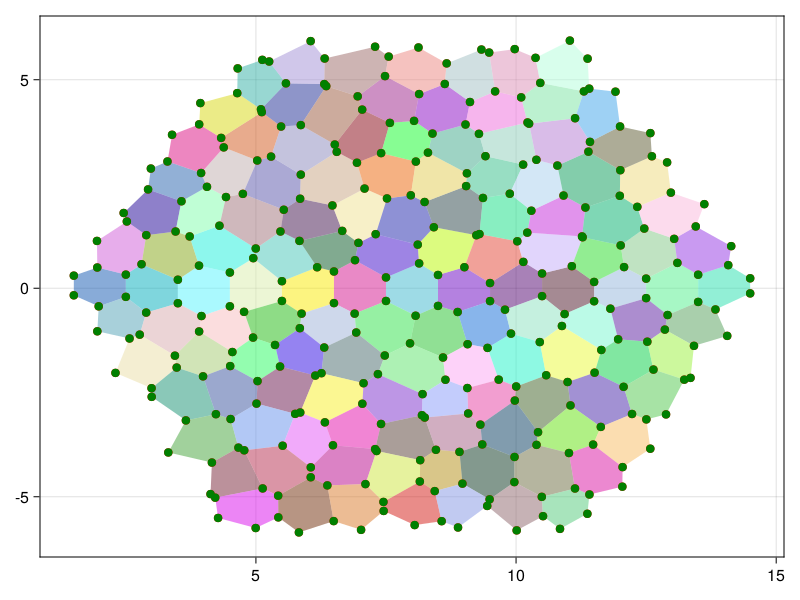

In [438]:
fig=Figure()
ax=Axis(fig[1, 1])
nCells=length(B[:,1])
nEdges=length(B[1,:])
nVerts=length(R)
#Plot cells
    for i = 1:nCells
        orderedVertices, orderedEdges = orderAroundCell(A,B, i)
        poly!(ax, Point2f.(R[orderedVertices]), color=(getRandomColor(i), 0.5))
    end
    scatter!(ax, Point2f.(R), color=:red)
    scatter!(ax, Point2f.(Rnew), color=:green)
fig

In [386]:
shortEdges

UndefVarError: UndefVarError: `shortEdges` not defined

In [395]:
bCells

3-element Vector{Int64}:
 76
 94
 96

In [418]:
senseCheck(A, B; marker="Removing peripheral vertices")


String: "Non-zero values in BA: Removing peripheral vertices"

In [424]:
findall(x->x!=0,interiorVerts.==b)

1-element Vector{Int64}:
 127

In [439]:
C=0.5.*abs.(B)*abs.(A)
tangents=A*R
e_len=norm.(tangents)
#random interior vertex
#interiorVerts= findall(x->x!=0,ones(nVerts)-vec(0.5*abs.(ones(nCells)'*B)*abs.(A)))

for _=1:5
peripheralEdges=findall(x->x!=0,(ones(nCells)'*B)')
borderEdges=findall(x->x!=0,vec(A*(ones(nVerts)'-abs.(ones(nCells)'*B)*abs.(A))'))
interiorEdges=setdiff(1:nEdges, vcat(peripheralEdges, borderEdges))
shortEdges=intersect(findall(x->x<0.3,e_len), interiorEdges)
        
for j in shortEdges
        
        # a=rand(interiorVerts) #random interior vertex

        # a_edge=rand(setdiff(findall(x->x!=0,A[:, a]), a))

        # b=setdiff(findall(x->x!=0,A[a_edge, :]), a)[1] #vertex on other end of random edge

        a,b=findall(x->x!=0,A[j, :])


        aCells = findall(i->i!=0,C[:,a])            
        bCells = findall(i->i!=0,C[:,b])            
        if length(aCells)>1 && length(bCells) > 1 # Exclude edges for which one vertex belongs to only one cell
                # Find cells P, Q, R, S surrounding vertices a and b
                Q = findall(i->i>0,B[:,j])[1] # Assume edge j has positive (clockwise) orientation with respect to cell Q
                S = findall(i->i<0,B[:,j])[1] # Assume edge j has negative (anti-clockwise) orientation with respect to cell S                
                aEdges = findall(x->x!=0,A[:,a])                # Find all edges around vertex a
                k = setdiff(aEdges,findall(x->x!=0,B[Q,:]))[1]  # Find edge k around vertex a that is not shared by cell Q
                bEdges = findall(x->x!=0,A[:,b])                # Find all edges around vertex b
                m = setdiff(bEdges,findall(x->x!=0,B[S,:]))[1]  # Find edge m around vertex b that is not shared by cell S                    
                # Assume cell P shares vertex a, which has positive orientation with respect to edge j
                P = setdiff(aCells, [Q,S]) # NB This is an array that may have 1 element or be empty since cell P may not exist if vertex a is at the periphery, but the algorithm is generalised to accommodate this
                # Assume cell R shares vertex b, which has negative orientation with respect to edge j
                K = setdiff(bCells, [Q,S]) # NB This is an array that may have 1 element or be empty since cell R may not exist if vertex b is at the periphery, but the algorithm is generalised to accommodate this    
                # Remove edge j from cells Q and S, assuming orientation from clockwise rotation of edge j
                B[Q,j] = 0; B[S,j] = 0
                # Add edge j to cells R and P, assuming orientation from clockwise rotation of edge j
                B[K,j] .= 1; B[P,j] .= -1 # NB using . notation here and passing R and P as an array rather than a single value accommodates the possibility that R or P is an empty array
                # Add vertex b to edge k, setting orientation from previous orientation of edge a
                A[k,b] = A[k,a]
                # Remove vertex a from edge k
                A[k,a] = 0
                # Add vertex a to edge m, setting orientation from previous orientation of edge b
                A[m,a] = A[m,b]
                # Remove vertex b from edge m 
                A[m,b] = 0
             
        end
        C=0.5.*abs.(B)*abs.(A)
        tangents=A*R
        e_len=norm.(tangents)
end
end

In [410]:
sB*A

127×294 SparseMatrixCSC{Int64, Int64} with 764 stored entries:
⎡⣠⠐⠠⡉⡁⠀⠦⢀⡀⠂⠈⠀⢴⡈⢲⠠⠂⣀⠼⣀⠐⠄⠂⠄⢈⠀⠠⠇⠀⠁⠀⠀⠔⠄⠀⠒⣐⠔⡀⡂⎤
⎢⠀⠛⢁⠁⢀⡜⣄⠁⠀⠤⠊⠠⣠⠈⠋⣅⠂⢁⡚⠀⠊⡄⠂⡀⠀⠘⢰⡥⠀⡁⠀⡀⣱⠰⠀⠲⠥⡒⠀⠂⎥
⎢⠘⠇⡄⠢⡈⢠⢀⠲⠛⢠⡁⠀⠂⠀⡌⠄⢊⠜⡈⠒⡀⠀⡄⢥⠰⢀⠌⠀⠀⠨⠠⠀⠅⠉⠀⠀⠖⡁⠔⠃⎥
⎢⠀⠄⠰⢀⠠⠉⠊⡀⢆⠈⠅⢈⠓⠂⠢⠆⡤⢔⠡⡂⠀⠀⢡⣖⢀⡐⠈⠈⢀⢢⠘⠋⠐⢩⠀⢀⠃⠁⢀⠼⎥
⎢⠐⠀⢃⠀⠳⢠⢔⠈⠠⠘⠆⣂⢤⡄⠄⡂⠐⡀⠂⡀⠄⠠⠃⣈⠉⢢⠘⢀⡈⡈⠠⠸⠁⢆⠀⠰⠀⠄⠊⢑⎥
⎢⠰⠂⡉⡄⠤⢀⡄⠐⢀⠶⢀⡝⠀⠆⠀⡄⡡⠉⠈⠀⡈⢤⠈⢁⠂⠇⠐⢀⡘⠐⠃⢰⠂⠃⠀⢋⢀⢀⠆⠃⎥
⎢⠠⠄⡒⡀⣄⠋⣌⠀⠃⠖⢠⠫⠀⠏⠘⠐⡠⠀⠀⠨⠡⢌⢔⢀⠅⢈⢄⠨⠑⠁⠂⡄⡀⠓⡐⠆⢠⢀⠰⠀⎥
⎢⡠⠠⠐⡙⢈⠕⢠⠐⠃⠀⢀⠁⠀⠘⠐⠐⠁⢄⠁⢸⡣⢢⠜⠀⠂⢁⢄⠀⢕⠀⠂⢄⡀⠐⣔⡀⢀⢈⠠⠀⎥
⎣⠀⠂⠀⠈⠊⠀⠀⠓⠀⠁⠀⠀⠀⠘⠀⠐⠈⠀⠁⠐⠁⠀⠈⠀⠀⠉⠀⠂⠘⠀⠚⠉⠈⠀⠐⠀⠀⠈⠁⠀⎦

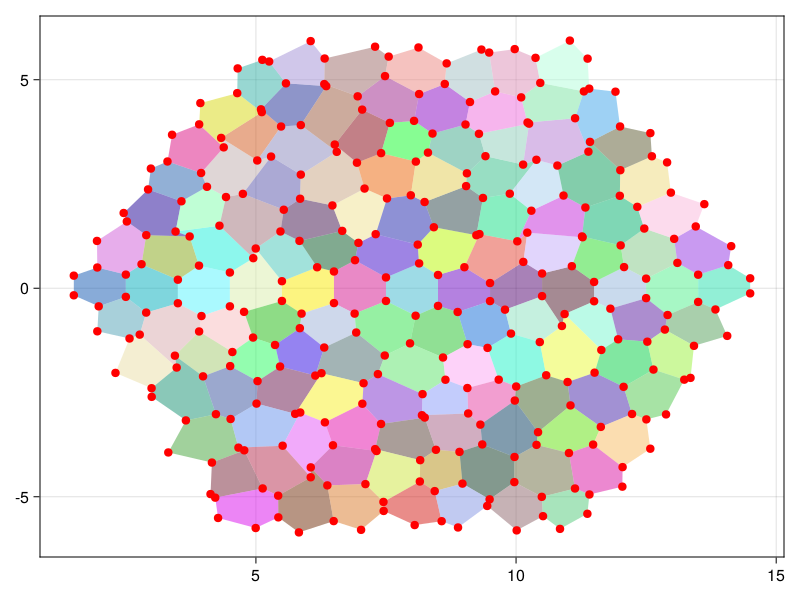

In [440]:
fig=Figure()
ax=Axis(fig[1, 1])
nCells=length(B[:,1])
nVerts=length(R)
#Plot cells
    for i = 1:nCells
        orderedVertices, orderedEdges = orderAroundCell(A,B, i)
        poly!(ax, Point2f.(R[orderedVertices]), color=(getRandomColor(i), 0.5))
    end
    scatter!(ax, Point2f.(R), color=:red)
fig

In [390]:
orderedVertices

UndefVarError: UndefVarError: `orderedVertices` not defined